# Analyse 2d brain models (z-sliced)

* check models are correctly laoded
* check first results (runability)
* observe deformation fields
* clustering of tumour type (HGG vs LGG)
* latent interpolations between subjects

In [1]:
### Base ###
import os
import sys
import csv
from argparse import Namespace
import pandas as pd
import numpy as np 
import torch 
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as data_utils
from torchvision.utils import save_image
import fnmatch
import itertools
import math
from sklearn.decomposition import PCA
import PIL.Image as pimg
import pytorch_lightning as pl

### Visualization ###
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family':'serif','serif':['Palatino']})

parent = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))
sys.path.insert(0, parent)
os.chdir(parent)
print('Setting root path to : {}'.format(parent))

from src.support.base_miccai import *
from src.in_out.datasets_miccai import ZeroOneT12DDataset
from src.core.models.bayesian_atlas_2dmiccai import VariationalMetamorphicAtlas2dExecuter

Setting root path to : /network/lustre/dtlake01/aramis/users/paul.vernhet/Scripts/Ongoing/MICCAI2020/deepshape
Setting root path to : /network/lustre/dtlake01/aramis/users/paul.vernhet/Scripts/Ongoing/MICCAI2020/deepshape


In [2]:
# PATHS :
HOME_PATH = '/network/lustre/dtlake01/aramis/users/paul.vernhet'
NIFTI_PATH = os.path.join(HOME_PATH, 'Data/MICCAI_dataset/2_datasets/2_t1ce_normalized')
BRATS_TENSORS_PATH = os.path.join(HOME_PATH, 'Data/MICCAI_dataset/3_tensors3d/2_t1ce_normalized/0_reduction')

EXPERIMENTS_DIR = os.path.join(HOME_PATH, 'Results/MICCAI/2dBraTs/2D_rdm_slice2_normalization_1_reduction/VAE_2020-03-05-01-59-17')
OUTPUT_INTERP_DIR = os.path.join(EXPERIMENTS_DIR, 'analyses_results')
os.makedirs(OUTPUT_INTERP_DIR, exist_ok=True)
val_ckpt_file = os.path.join(EXPERIMENTS_DIR, 'lightning_logs/version_0/checkpoints/_ckpt_epoch_99.ckpt')
val_metavar_file = os.path.join(EXPERIMENTS_DIR, 'lightning_logs/version_0', 'meta_tags.csv')
train_ckpt_file = os.path.join(EXPERIMENTS_DIR, 'checkpoints/train_model__epoch_9820.pth')
train_metavar_file = os.path.join(EXPERIMENTS_DIR, 'checkpoints', 'train_hparams_9820.csv')
assert os.path.exists(train_ckpt_file) and os.path.exists(train_metavar_file)

Manually loading models ( hparams | weights )

In [3]:
# ======================
# Load hparams best train

hparams = load_hparams_from_tags_csv(train_metavar_file)
print('>> hparams loaded')

# ======================
# Initialize model | load weights

model_executer = VariationalMetamorphicAtlas2dExecuter(hparams)
initial_template = model_executer.model.template_intensities.clone()

checkpoint = torch.load(train_ckpt_file, map_location=lambda storage, loc: storage)
model_executer.model.load_state_dict(checkpoint)
loaded_template = model_executer.model.template_intensities.clone()
print('>> model_executer loaded')
assert not torch.all(initial_template.eq(loaded_template))

# ======================
# Initialize GPUs

torch.manual_seed(hparams.seed)
np.random.seed(hparams.seed)

if hparams.cuda:
    print('>> GPU available.')
    DEVICE = torch.device('cuda')
    torch.cuda.set_device(hparams.num_gpu)
    torch.cuda.manual_seed(hparams.seed)
else:
    DEVICE = torch.device('cpu')
    print('>> CUDA is not available. Overridding with device = "cpu".')
    print('>> OMP_NUM_THREADS will be set to ' + str(hparams.num_threads))
    os.environ['OMP_NUM_THREADS'] = str(hparams.num_threads)
    torch.set_num_threads(hparams.num_threads)
    
model_executer = model_executer.to(DEVICE)
model = model_executer.model

# ======================
# create datasets

dataset_train = ZeroOneT12DDataset(os.path.join(hparams.data_tensor_path, 'train'), hparams.nb_train,
                                   sliced_dim=hparams.sliced_dim,
                                   reduction=hparams.downsampling_data, init_seed=hparams.seed,
                                   check_endswith='pt')
train_loader = data_utils.DataLoader(dataset_train, batch_size=hparams.batch_size, shuffle=True)
dataset_val = ZeroOneT12DDataset(os.path.join(hparams.data_tensor_path, 'test'), hparams.nb_test,
                                 reduction=hparams.downsampling_data, init_seed=hparams.seed,
                                 sliced_dim=hparams.sliced_dim,
                                 check_endswith='pt')
val_loader = data_utils.DataLoader(dataset_val, batch_size=hparams.batch_size, shuffle=True)

  2%|▏         | 5/330 [00:00<00:07, 45.78it/s]

>> hparams loaded
>> Creating dataset with 330 files (from 335 available)
>> Creating dataset with 16 files (from 125 available)
>> Computing online statistics for dataset ...


100%|██████████| 330/330 [00:07<00:00, 42.96it/s]


>> Template intensities are torch.Size([1, 160, 192]) = 30720 parameters
>> Encoder2d__5_down has 929128 parameters
>> DeepDecoder2d__5_up has 933200 parameters
>> DeepDecoder2d__4_up has 465920 parameters
>> Metamorphic 2D BayesianAtlas has 2358968 parameters
>> model_executer loaded
>> GPU available.
>> Creating dataset with 330 files (from 335 available)
>> Creating dataset with 16 files (from 125 available)


In [4]:
noise_dimension = model.noise_dimension

# PRINT TEMPLATE
img_01 = 255 * initial_template.squeeze().detach().cpu().numpy()
img_02 = 255 * loaded_template.squeeze().detach().cpu().numpy()

figsize = 6
f, ax = plt.subplots(1, 2, figsize=(2*figsize, figsize))
ax[0].imshow(img_01, cmap='gray')
ax[1].imshow(img_02, cmap='gray')
plt.axis('off')
plt.title('Learned template')
plt.show()

# Check data | reconstruction 

### 1. Qualitative analysis on 5 images

Observe on examples the evolution of scheme

In [5]:
# ====================
indexes = [0, 1, 2, 3, 4]
data_loader = train_loader
n = min(len(indexes), hparams.nb_train)
intensities_to_write = []
for batch_idx, (intensities, _) in enumerate(data_loader):
    if n <= 0:
        break
    bts = intensities.size(0)
    nb_selected = min(bts, n)
    intensities_to_write.append(intensities[:nb_selected])
    n = n - nb_selected
observations = torch.cat(intensities_to_write).to(DEVICE)

# ====================
# Deform

s, _, a, _ = model.encode(observations)

# INIT
bts = s.size(0)
assert bts == a.size(0)
ntp = model.number_of_time_points
kws = model.kernel_width__s
kwa = model.kernel_width__a
dim = model.dimension
gs = model.grid_size
dgs = model.downsampled_grid_size
dsf = model.downsampling_grid

v_star = model.decoder__s(s) - model.v_star_average.type(str(s.type()))
n_star = model.decoder__a(a) - model.n_star_average.type(str(a.type()))

# GAUSSIAN SMOOTHING
v = batched_vector_smoothing(v_star, kws, scaled=False)
n = batched_scalar_smoothing(n_star, kwa, scaled=False)

# NORMALIZE
s_norm_squared = torch.sum(s.view(bts, -1) ** 2, dim=1)
a_norm_squared = torch.sum(a.view(bts, -1) ** 2, dim=1)
v_norm_squared = torch.sum(v * v_star, dim=tuple(range(1, dim + 2)))
n_norm_squared = torch.sum(n * n_star, dim=tuple(range(1, dim + 2)))
normalizer__s = torch.where(s_norm_squared > 1e-10,
                            torch.sqrt(s_norm_squared / v_norm_squared),
                            torch.from_numpy(np.array(0.0)).float().type(str(s.type())))
normalizer__a = torch.where(a_norm_squared > 1e-10,
                            torch.sqrt(a_norm_squared / n_norm_squared),
                            torch.from_numpy(np.array(0.0)).float().type(str(a.type())))

normalizer__s = normalizer__s.view(*([bts] + (dim + 1) * [1])).expand(v.size())
normalizer__a = normalizer__a.view(*([bts] + (dim + 1) * [1])).expand(n.size())
v = v * normalizer__s
n = n * normalizer__a

# FLOW
grid = torch.stack(torch.meshgrid([torch.linspace(0.0, elt - 1.0, delt) for elt, delt in zip(gs, dgs)])
                   ).type(str(s.type())).view(*([1, dim] + list(dgs))).repeat(*([bts] + (dim + 1) * [1]))

x = grid.clone() + v / float(2 ** ntp)
for t in range(ntp):
    x += batched_vector_interpolation_adaptive(x - grid, x, dsf)

# INTERPOLATE
intensities = batched_scalar_interpolation_adaptive(model.template_intensities + n, x).float()

# WRITE
template = model.template_intensities.float().mul(255).cpu()

images = []
images_ = []
sliced_images = []
for i in range(bts):
    # Get data
    appearance = (model.template_intensities + n[i]).float().cpu().mul(255)
    shape = batched_scalar_interpolation_adaptive(model.template_intensities.float().cpu(),
                                                  x[i].float().unsqueeze(0).detach().cpu())[0].mul(255)
    metamorphosis = intensities[i].float().mul(255).cpu()
    target = observations[i].float().mul(255).cpu()
    
    # Get sliced image
    images_i = [template.squeeze(1), appearance.squeeze(1), shape.squeeze(1),
                metamorphosis.squeeze(1), target.squeeze(1)]
    images_ += images_i
    images.append(images_i)
images_ = torch.cat(images_)
vmax = torch.max(images_).detach().numpy()
empiric_noise_std = torch.sqrt(torch.sum((intensities - observations) ** 2) / float(intensities.size(0) * noise_dimension)).detach().cpu().numpy()
print('empiric_noise_std = %.2E' % empiric_noise_std)

empiric_noise_std = 2.77E-02


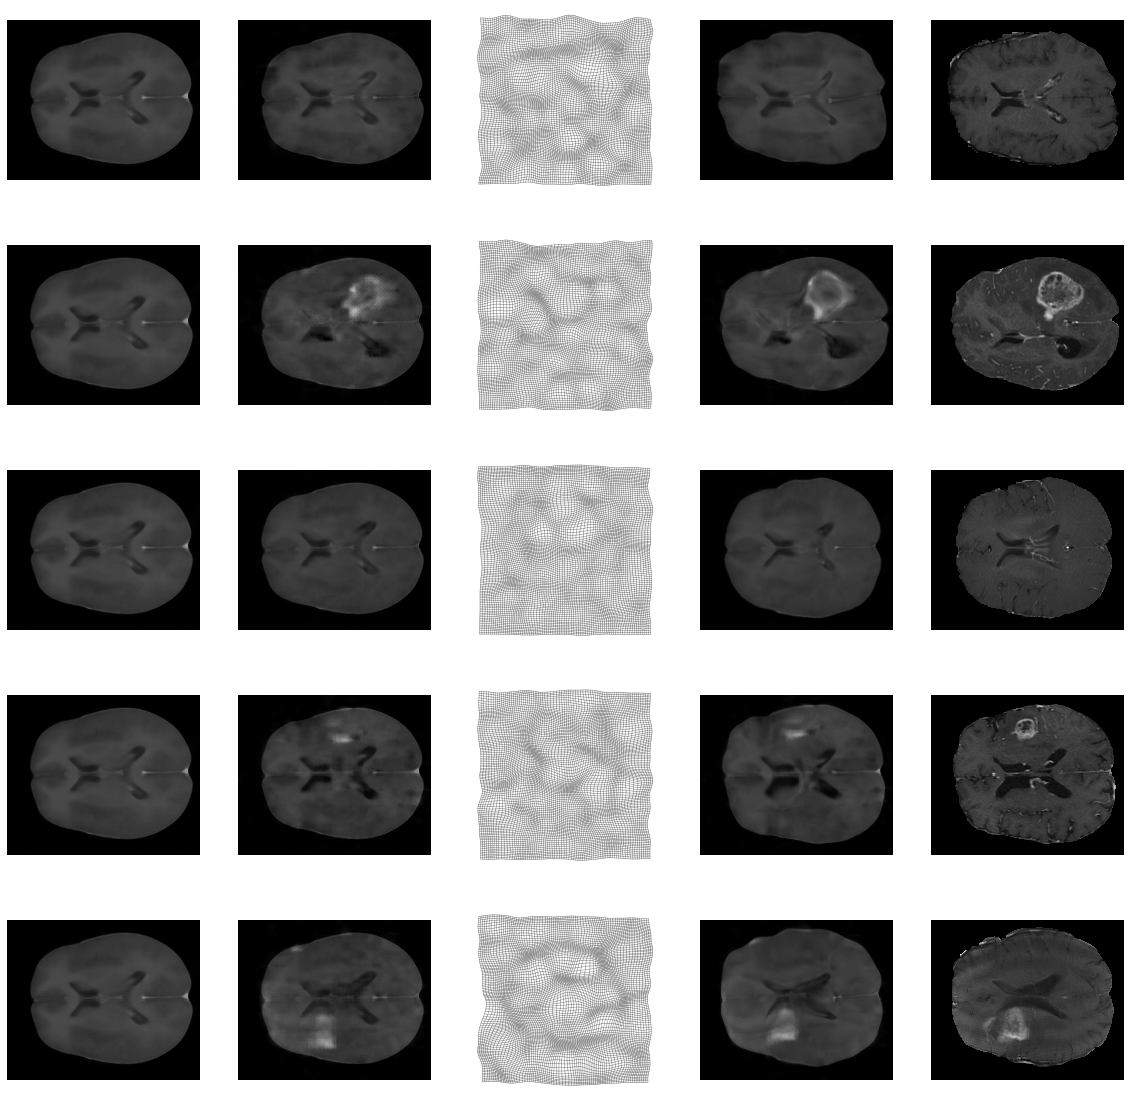

In [7]:
# ====================
# Plot
%matplotlib inline   
# I don't knwo why I have to call it again for viz to work ...

figsize = 4
nrows = len(indexes)
ncols = len(images_i)

f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))
for i in range(nrows):
    for j in range(ncols):
        ax = axes.reshape(nrows, ncols)[i, j]
        index = indexes[i]

        img = images[index][j].detach().cpu().numpy()[0]
        if j != 2:
            ax.imshow(img, cmap='gray', vmin=0.0, vmax=vmax)

        if j == 2:
            g = x[index].permute(1, 2, 0).detach().cpu().numpy()
            ax.plot([g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 
                    [g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()], 'grey', linewidth=0.5)
            ax.plot([g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()],
                    [g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()], 'grey', linewidth=0.5)
        
        ax.axis('off')
plt.show()

Observe evolution of template increments :
- the idea is to average out normal deformations vs pathological ones
- keep for later

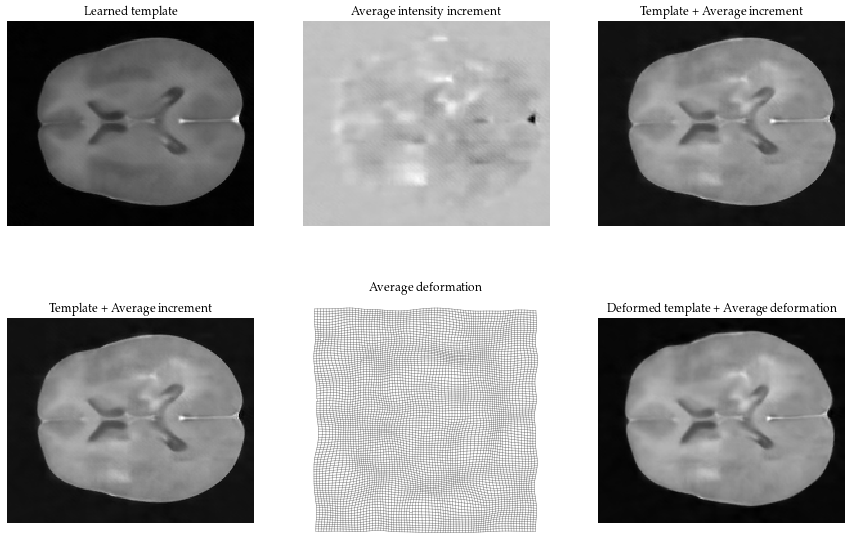

In [8]:
figsize = 5
nrows = 2
ncols = 3

f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))

# ====================
# Learned template
template = model.template_intensities.detach().cpu().numpy()[0].squeeze()
img = template
ax = axes[0, 0]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Learned template')

# ====================
# Average (on small batch) intensity increment
n_average = torch.mean(n, dim=0)[0].detach().cpu().numpy()
img = n_average
ax = axes[0, 1]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Average intensity increment')

# ====================
# Difference
img = template + n_average
ax = axes[0, 2]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Template + Average increment')

# ====================
# Learned template + increment
img = template + n_average
ax = axes[1, 0]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Template + Average increment')

# ====================
# Average deformation
x_average = torch.mean(x, dim=0)
g = x_average.permute(1, 2, 0).detach().cpu().numpy()
ax = axes[1, 1]
ax.plot([g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 
        [g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()], 'grey', linewidth=0.5)
ax.plot([g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()],
        [g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()], 'grey', linewidth=0.5)
ax.axis('off')
ax.set_title('Average deformation')

# ====================
# Difference
img = batched_scalar_interpolation_adaptive(model.template_intensities + torch.mean(n, dim=0),
                                            x_average.unsqueeze(0))[0].detach().cpu().numpy()[0]

ax = axes[1, 2]
ax.imshow(img, cmap='gray')
ax.axis('off')
ax.set_title('Deformed template + Average deformation')

plt.show()

Observe averaging variations and masking for tumor localization:

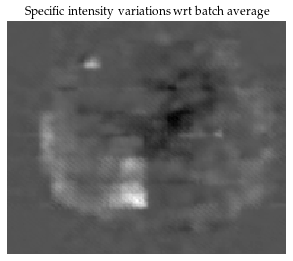

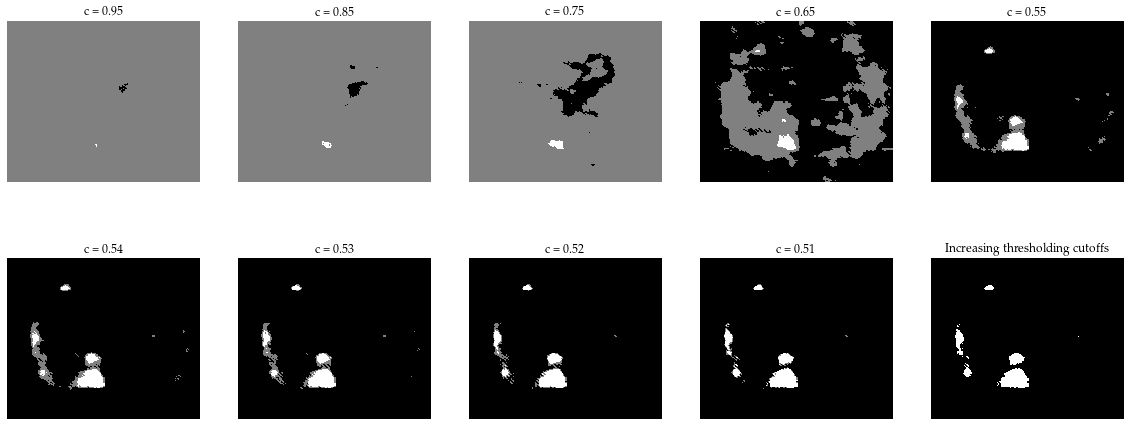

In [9]:
index = 4

# =================
# variations to mean intensities
img = n[index, 0].detach().cpu().numpy() - n_average
img = img - np.mean(img)

figsize = 5
f = plt.figure(figsize=(figsize, figsize))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Specific intensity variations wrt batch average')
plt.show()

# =================
# threshold cutoffs

thresholds = [0.95, 0.85, 0.75, 0.65, 0.55, 0.54, 0.53, 0.52, 0.51, 0.50]
figsize = 4
ncols = min(len(thresholds), 5)
nrows = len(thresholds) // ncols

f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))
for k, c in enumerate(thresholds):
    ax = np.ravel(axes)[k]

    mi = np.min(img)
    ma = np.max(img)
    img_thres = 1.0 * (img > mi + c * (ma - mi)) - 1.0 * (img < ma - c * (ma - mi))

    ax.imshow(img_thres, cmap='gray')
    ax.axis('off')
    ax.set_title('c = %.2f' % c)
plt.title('Increasing thresholding cutoffs')
plt.show()

Latent interpolation bewteen two brains status:

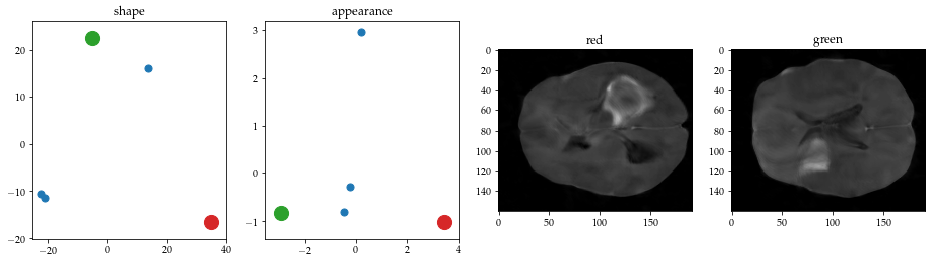

>> normalizer shape  = 7.804E+00 ; max(abs(v)) = 7.956E+00
>> normalizer appea  = 1.432E+01 ; max(abs(n)) = 4.105E-01
torch.max(n) = 0.410 

>> normalizer shape  = 7.718E+00 ; max(abs(v)) = 9.961E+00
>> normalizer appea  = 1.044E+01 ; max(abs(n)) = 2.645E-01
torch.max(n) = 0.265 

>> normalizer shape  = 7.805E+00 ; max(abs(v)) = 7.792E+00
>> normalizer appea  = 9.106E+00 ; max(abs(n)) = 3.184E-01
torch.max(n) = 0.183 

>> normalizer shape  = 9.176E+00 ; max(abs(v)) = 7.884E+00
>> normalizer appea  = 1.033E+01 ; max(abs(n)) = 3.347E-01
torch.max(n) = 0.148 

>> normalizer shape  = 1.018E+01 ; max(abs(v)) = 1.008E+01
>> normalizer appea  = 1.169E+01 ; max(abs(n)) = 3.965E-01
torch.max(n) = 0.396 

>> normalizer shape  = 7.769E+00 ; max(abs(v)) = 8.053E+00
>> normalizer appea  = 1.488E+01 ; max(abs(n)) = 4.368E-01
torch.max(n) = 0.437 

>> normalizer shape  = 7.821E+00 ; max(abs(v)) = 7.875E+00
>> normalizer appea  = 1.029E+01 ; max(abs(n)) = 2.541E-01
torch.max(n) = 0.254 

>> normalizer

In [10]:
zs = s.detach().cpu().numpy()
za = a.detach().cpu().numpy()

index_a = 1
index_b = 4

figsize = 4
ncols = 4
nrows = 1
f, axes = plt.subplots(nrows, ncols , figsize=(ncols*figsize, nrows*figsize))

# ====================
# PCA on latent shapes
pca = PCA(2)
zs = pca.fit_transform(zs)

ax = axes.ravel()[0]
ax.scatter(zs[:, 0], zs[:, 1], s=50, c='tab:blue')
ax.scatter(zs[index_a, 0], zs[index_a, 1], s=200, c='tab:red')
ax.scatter(zs[index_b, 0], zs[index_b, 1], s=200, c='tab:green')
ax.set_title('shape')

# ====================
# PCA on latent appearances
pca = PCA(2)
za = pca.fit_transform(za)

ax = axes.ravel()[1]
ax.scatter(za[:, 0], za[:, 1], s=50, c='tab:blue')
ax.scatter(za[index_a, 0], za[index_a, 1], s=200, c='tab:red')
ax.scatter(za[index_b, 0], za[index_b, 1], s=200, c='tab:green')
ax.set_title('appearance')

# ====================
# Image A

ax = axes.ravel()[2]
img = images[index_a][3].detach().cpu().numpy()[0]
ax.imshow(img, cmap='gray', vmin=0.0, vmax=vmax)
ax.set_title('red')

# ====================
# Image B

ax = axes.ravel()[3]
img = images[index_b][3].detach().cpu().numpy()[0]
ax.imshow(img, cmap='gray', vmin=0.0, vmax=vmax)
ax.set_title('green')

plt.show()

# ====================
# INTERPOLATIONS

s_start = s[index_a]
a_start = a[index_a]
s_end = s[index_b]
a_end = a[index_b]

T = 5
dt = 1.0 / float(T-1)

imgs = []
tol = 1e-10

# --------------------
# MIXED INTERPOLATION
for t in range(T): 
    at = (1.0 - t*dt) * a_start + t*dt * a_end
    st = (1.0 - t*dt) * s_start + t*dt * s_end
    
    img = torch.clamp(model(st.unsqueeze(0), at.unsqueeze(0))[0].mul(255), tol, 255. - tol)
    imgs.append(img)

# --------------------
# APPEARANCE INTERPOLATION
for t in range(T): 
    at = (1.0 - t*dt) * a_start + t*dt * a_end
    st = s_start
    
    img = torch.clamp(model(st.unsqueeze(0), at.unsqueeze(0))[0].mul(255), tol, 255. - tol)
    imgs.append(img)

# --------------------
# SHAPE INTERPOLATION
for t in range(T): 
    at = a_start
    st = (1.0 - t*dt) * s_start + t*dt * s_end
    
    img = torch.clamp(model(st.unsqueeze(0), at.unsqueeze(0))[0].mul(255), tol, 255. - tol)
    imgs.append(img)
    
imgs = torch.stack(imgs)
save_image(imgs, os.path.join(OUTPUT_INTERP_DIR,'4_interpolation__start_%d__end_%d.pdf' % (index_a, index_b)), 
           nrow=T, normalize=True, range=(0., float(torch.max(imgs).detach().cpu().numpy())))

### 2. Clustering and classification :

#### a) Latent space overview

In [11]:
# ====================
data_loader = train_loader
latent_s = []
latent_a = []
labels = []

for batch_idx, (intensities, filename) in enumerate(data_loader):
    observations = intensities.to(DEVICE)
    s, _, a, _ = model.encode(observations)
    for (s_i, a_i, fn_i) in zip(s, a, filename):
        latent_s.append(s_i.detach().clone())
        latent_a.append(a_i.detach().clone())
        labels.append(fn_i.split('_')[0].upper())

Quick overview of class separations :

In [101]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

colors = ['b', 'g']
colors_gmm = ['turquoise', 'darkorange']

cov_type = 'full'
gmm_full_h = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=0, n_init=20)
gmm_full_g = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=0, n_init=20)
gmm_s = GaussianMixture(n_components=2, covariance_type=cov_type, max_iter=200, random_state=1, n_init=20)
gmm_g = GaussianMixture(n_components=2, covariance_type=cov_type, max_iter=200, random_state=1, n_init=20)
gmm_a = GaussianMixture(n_components=2, covariance_type=cov_type, max_iter=200, random_state=2, n_init=20)

# ====================
# Clustering in latent space
X_train_s = np.array([e.cpu().numpy() for e in latent_s])
X_train_a = np.array([e.cpu().numpy() for e in latent_a])
X_train_full = np.hstack([X_train_s, X_train_a])

gmm_full.fit(X_train_full)
gmm_s.fit(X_train_s)
gmm_a.fit(X_train_a)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
                means_init=None, n_components=2, n_init=20,
                precisions_init=None, random_state=2, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

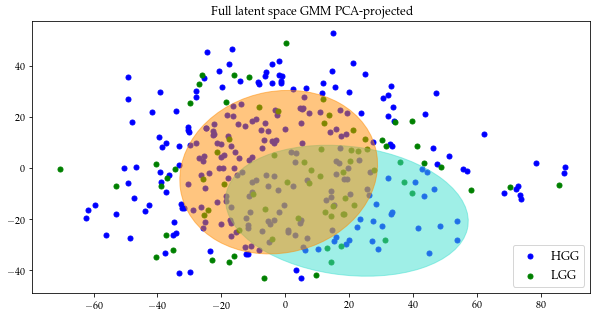

In [102]:
# ====================
# PCA reduction for viz | full
pca_full = PCA(2)
pca_full.fit(X_train_full)
X_train_full_pca = pca_full.transform(X_train_full)
means_pcaed = pca_full.components_ @ gmm_full.means_.T
batched_pca_comp = pca_full.components_[np.newaxis].repeat(2, axis=0)
res = np.matmul(batched_pca_comp, gmm_full.covariances_)
covariances_pcaed = np.matmul(res, batched_pca_comp.transpose(0, 2, 1))
assert np.array_equal(covariances_pcaed[0], pca_full.components_ @ gmm_full.covariances_[0] @ pca_full.components_.T), "check PCA is ok in size"

fig, ax = plt.subplots(figsize=(10, 5))

for color, lab in zip(colors, ['HGG', 'LGG']):
    # PCA-reduced data
    data = X_train_full_pca[ [e == lab for e in labels]]
    ax.scatter(data[:, 0], data[:, 1], s=25., color=color, label=lab)
    
# GMM - ellipses projected onto dimension
for i, (mean, covar, color) in enumerate(zip(
        means_pcaed, covariances_pcaed, colors_gmm)):
    v, w = np.linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

#y_train_pred = estimator.predict(X_train)
#train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
#plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
#         transform=h.transAxes)

plt.title('Full latent space GMM PCA-projected')
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

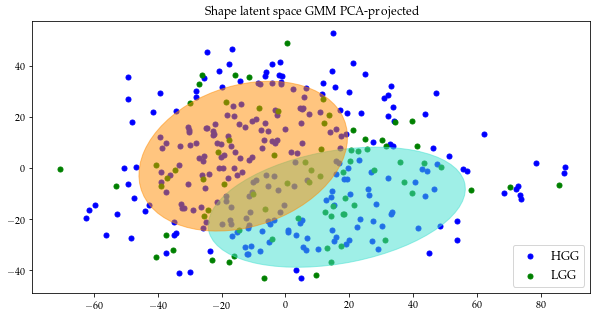

In [104]:
# ====================
# PCA reduction for viz | full
pca_s = PCA(2)
pca_s.fit(X_train_s)
X_train_s_pca = pca_s.transform(X_train_s)
means_pcaed = pca_s.components_ @ gmm_s.means_.T
batched_pca_comp = pca_s.components_[np.newaxis].repeat(2, axis=0)
res = np.matmul(batched_pca_comp, gmm_s.covariances_)
covariances_pcaed = np.matmul(res, batched_pca_comp.transpose(0, 2, 1))
assert np.array_equal(covariances_pcaed[0], pca_s.components_ @ gmm_s.covariances_[0] @ pca_s.components_.T), "check PCA is ok in size"

fig, ax = plt.subplots(figsize=(10, 5))

for color, lab in zip(colors, ['HGG', 'LGG']):
    # PCA-reduced data
    data = X_train_s_pca[ [e == lab for e in labels]]
    ax.scatter(data[:, 0], data[:, 1], s=25., color=color, label=lab)
    
# GMM - ellipses projected onto dimension
for i, (mean, covar, color) in enumerate(zip(
        means_pcaed, covariances_pcaed, colors_gmm)):
    v, w = np.linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

#y_train_pred = estimator.predict(X_train)
#train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
#plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
#         transform=h.transAxes)

plt.title('Shape latent space GMM PCA-projected')
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

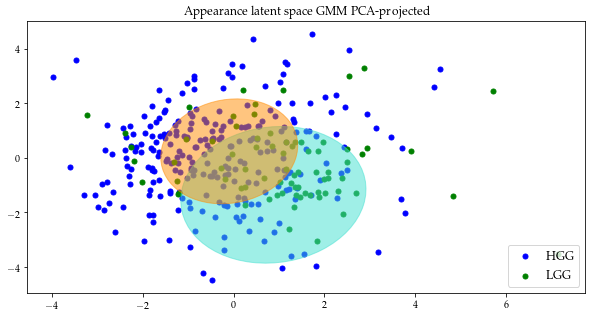

In [105]:
# ====================
# PCA reduction for viz | full
pca_a = PCA(2)
pca_a.fit(X_train_a)
X_train_a_pca = pca_a.transform(X_train_a)
means_pcaed = pca_a.components_ @ gmm_a.means_.T
batched_pca_comp = pca_a.components_[np.newaxis].repeat(2, axis=0)
res = np.matmul(batched_pca_comp, gmm_a.covariances_)
covariances_pcaed = np.matmul(res, batched_pca_comp.transpose(0, 2, 1))
assert np.array_equal(covariances_pcaed[0], pca_a.components_ @ gmm_a.covariances_[0] @ pca_a.components_.T), "check PCA is ok in size"

fig, ax = plt.subplots(figsize=(10, 5))

for color, lab in zip(colors, ['HGG', 'LGG']):
    # PCA-reduced data
    data = X_train_a_pca[ [e == lab for e in labels]]
    ax.scatter(data[:, 0], data[:, 1], s=25., color=color, label=lab)
    
# GMM - ellipses projected onto dimension
for i, (mean, covar, color) in enumerate(zip(
        means_pcaed, covariances_pcaed, colors_gmm)):
    v, w = np.linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

#y_train_pred = estimator.predict(X_train)
#train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
#plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
#         transform=h.transAxes)

plt.title('Appearance latent space GMM PCA-projected')
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

Other viz (but same spirit ...):

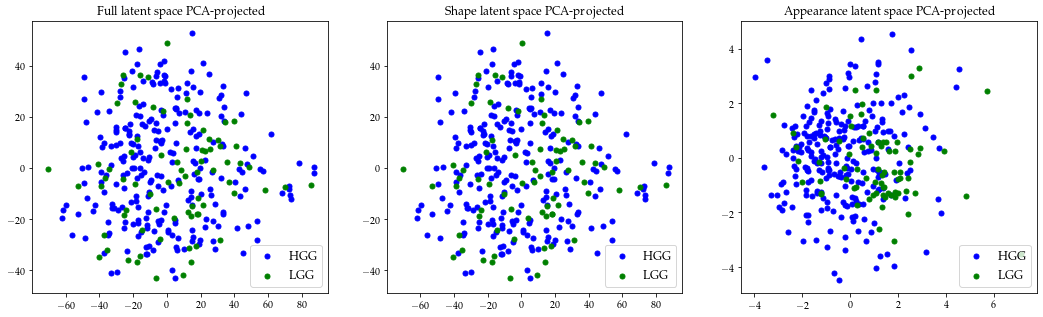

In [121]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

colors = ['b', 'g']
colors_gmm = ['turquoise', 'darkorange']

cov_type = 'full'
gmm_full_h = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=0, n_init=20)
gmm_full_g = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=0, n_init=20)
gmm_s_h = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=1, n_init=20)
gmm_s_g = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=1, n_init=20)
gmm_a_h = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=1, n_init=20)
gmm_a_g = GaussianMixture(n_components=1, covariance_type=cov_type, max_iter=200, random_state=2, n_init=20)

# ====================
# Approx classes with Gaussian 
X_train_s = np.array([e.cpu().numpy() for e in latent_s])
X_train_a = np.array([e.cpu().numpy() for e in latent_a])
X_train_full = np.hstack([X_train_s, X_train_a])

labels_H = [e == 'HGG' for e in labels]
labels_G = [e == 'LGG' for e in labels]

gmm_full_h.fit(X_train_full[labels_H])
gmm_full_g.fit(X_train_full[labels_G])
gmm_s_h.fit(X_train_s[labels_H])
gmm_s_g.fit(X_train_s[labels_G])
gmm_a_h.fit(X_train_a[labels_H])
gmm_a_g.fit(X_train_a[labels_G])

# ====================
# Observe intersection of classes :
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, (X_data, (gmm_h, gmm_g), name) in enumerate(zip([X_train_full, X_train_s, X_train_a], 
                                                 [[gmm_full_h, gmm_full_g],[gmm_s_h, gmm_s_g], [gmm_a_h, gmm_a_g]],
                                                 ['Full', 'Shape', 'Appearance'])):
    
    pca = PCA(2)
    pca.fit(X_data)
    X_data_pca = pca.transform(X_data)
    means_pcaed_h = (pca.components_ @ gmm_h.means_.T).T
    means_pcaed_g = (pca.components_ @ gmm_g.means_.T).T
    covariances_pcaed_h = pca.components_ @ gmm_h.covariances_.squeeze() @ pca.components_.T
    covariances_pcaed_g = pca.components_ @ gmm_g.covariances_.squeeze() @ pca.components_.T
    
    ax[i].scatter(X_data_pca[labels_H][:, 0], X_data_pca[labels_H][:, 1], s=25., color=colors[0], label='HGG')
    ax[i].scatter(X_data_pca[labels_G][:, 0], X_data_pca[labels_G][:, 1], s=25., color=colors[1], label='LGG')        

    # GMM - ellipses projected onto dimension
    #for j, (mean, covar, col) in enumerate(zip([means_pcaed_h, means_pcaed_g], [covariances_pcaed_h, covariances_pcaed_g], colors_gmm)):
    #    v, w = np.linalg.eigh(covar)
    #    v = 2. * np.sqrt(2.) * np.sqrt(v)
    #    u = w[0] / np.linalg.norm(w[0])
    #    angle = np.arctan(u[1] / u[0])
    #    angle = 180. * angle / np.pi  # convert to degrees
    #    ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=col)
    #    ell.set_clip_box(ax[i].bbox)
    #    ell.set_alpha(0.5)
    #    ax[i].add_artist(ell)

    #y_train_pred = estimator.predict(X_train)
    #train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    #plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
    #         transform=h.transAxes)

    ax[i].set_title('{} latent space PCA-projected'.format(name))
    ax[i].legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
    
plt.show()

### b)Classification tests :

SVM
-----------------------------
Inspired by [sklearn example](https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py).

Training on Full with 264 train | 66 test
HGG : 254 | LGG : 76
Balanced accuracy : 0.50
Training on Shape with 264 train | 66 test
HGG : 254 | LGG : 76
Balanced accuracy : 0.50
Training on Appearance with 264 train | 66 test
HGG : 254 | LGG : 76
Balanced accuracy : 0.76


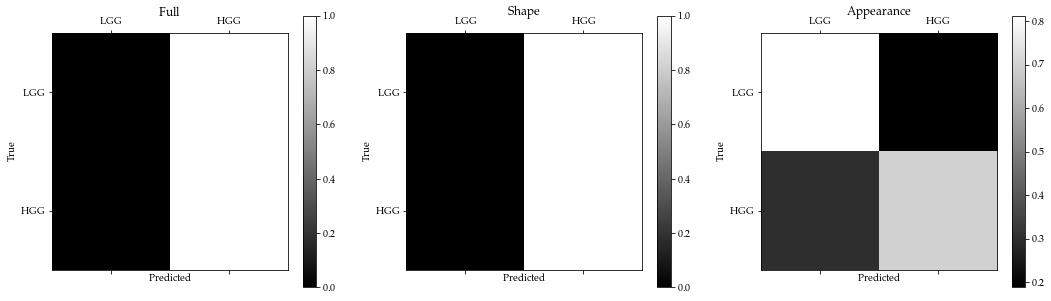

In [166]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, (X_data, name) in enumerate(zip([X_train_full, X_train_s, X_train_a], 
                                                 ['Full', 'Shape', 'Appearance'])):
    
    # Train | test
    n_sample = len(X_data)
    order = np.random.permutation(n_sample)
    X = X_data[order]
    y = np.array([1 if e == 'HGG' else 0 for e in labels])[order].astype(np.float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('Training on {} with {} train | {} test'.format(name, len(y_train), len(y_test)))
    print('HGG : {} | LGG : {}'.format(np.sum(y == 1), np.sum(y == 0)))
    
    # PCAed data
    pca = PCA(2)
    pca.fit(X_data)
    
    # fit the model
    clf = SVC(kernel='rbf', gamma=.1, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    # results
    print('Balanced accuracy : {:.2f}'.format(balanced_accuracy_score(y_test, clf.predict(X_test))))
    np.set_printoptions(precision=2)
    cm = confusion_matrix(y_test, clf.predict(X_test).round(), normalize='true')
    cax = ax[i].matshow(cm, cmap=plt.cm.gray)
    plt.colorbar(cax, ax=ax[i])
    ax[i].set_xticklabels([''] + ['LGG', 'HGG'])
    ax[i].set_yticklabels([''] + ['LGG', 'HGG'])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(name)
plt.show()

MLP
-----------------------------

Training on Full with 264 train | 66 test
HGG : 254 | LGG : 76
Balanced accuracy : 0.53
Training on Shape with 264 train | 66 test
HGG : 254 | LGG : 76
Balanced accuracy : 0.62
Training on Appearance with 264 train | 66 test
HGG : 254 | LGG : 76
Balanced accuracy : 0.66


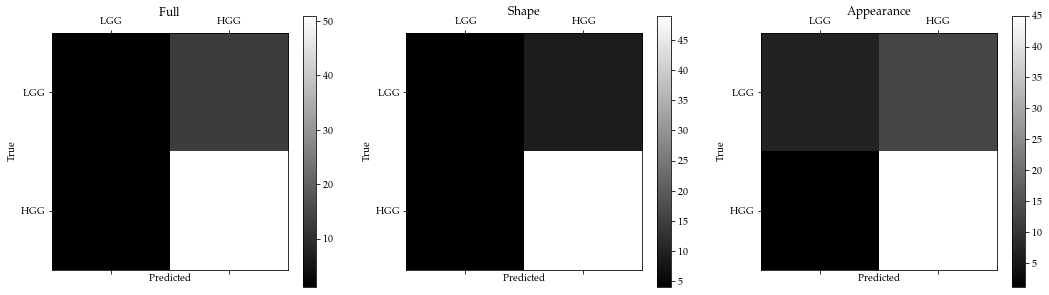

In [167]:
from sklearn.neural_network import MLPClassifier

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, (X_data, name) in enumerate(zip([X_train_full, X_train_s, X_train_a], 
                                                 ['Full', 'Shape', 'Appearance'])):
    
    # Train | test
    n_sample = len(X_data)
    order = np.random.permutation(n_sample)
    X = X_data[order]
    y = np.array([1 if e == 'HGG' else 0 for e in labels])[order].astype(np.float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('Training on {} with {} train | {} test'.format(name, len(y_train), len(y_test)))
    print('HGG : {} | LGG : {}'.format(np.sum(y == 1), np.sum(y == 0)))
    
    # PCAed data
    pca = PCA(2)
    pca.fit(X_data)
    
    # fit the model
    clf = MLPClassifier((5, 2), max_iter=1000)
    clf.fit(X_train, y_train)
    
    # results
    print('Balanced accuracy : {:.2f}'.format(balanced_accuracy_score(y_test, clf.predict(X_test))))
    np.set_printoptions(precision=2)
    cm = confusion_matrix(y_test, clf.predict(X_test), normalize=None)
    cax = ax[i].matshow(cm, cmap=plt.cm.gray)
    plt.colorbar(cax, ax=ax[i])
    ax[i].set_xticklabels([''] + ['LGG', 'HGG'])
    ax[i].set_yticklabels([''] + ['LGG', 'HGG'])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(name)
plt.show()